In [36]:
import pandas as pd
import json
from environs import Env
from neo4j import GraphDatabase

env = Env()
env.read_env()

EPIGRAPHDB_SERVER = env.str("EPIGRAPHDB_SERVER")
EPIGRAPHDB_USER = "neo4j"
EPIGRAPHDB_PORT = env.str("EPIGRAPHDB_PORT")
EPIGRAPHDB_PASSWORD = env.str("EPIGRAPHDB_PASSWORD")
print(EPIGRAPHDB_PORT)

epigraphdb_driver = GraphDatabase.driver(
    "bolt://{server_name}:{port}".format(
        server_name=EPIGRAPHDB_SERVER, port=EPIGRAPHDB_PORT),
    auth=(EPIGRAPHDB_USER, EPIGRAPHDB_PASSWORD))

session = epigraphdb_driver.session()

def query_to_df(query):
    print(query)
    data=session.run(query).data()
    df = pd.json_normalize(data)
    return(df)

37687


 - explore trastusumab
 - explore taximofen
 
 - weird enterobiasis??

## Basic test1: drugs to disease

In [37]:
query="""
match (drug:Drug)
where toLower(drug.label) contains "trastuzumab"
return drug.label, drug.id
"""
df= query_to_df(query)
df


match (drug:Drug)
where toLower(drug.label) contains "trastuzumab"
return drug.label, drug.id



,drug.label,drug.id
0,TRASTUZUMAB EMTANSINE,http://identifiers.org/chembl.compound/CHEMBL1...
1,TRASTUZUMAB DERUXTECAN,http://identifiers.org/chembl.compound/CHEMBL4...
2,TRASTUZUMAB,http://identifiers.org/chembl.compound/CHEMBL1...


In [38]:
# drugs to disease
query="""
match (drug:Drug)-[:OPENTARGETS_DRUG_TO_DISEASE]->(disease:Disease)
where toLower(drug.label) contains "trastuzumab"
return drug.label, drug.id, disease.label
"""
df= query_to_df(query)
df


match (drug:Drug)-[:OPENTARGETS_DRUG_TO_DISEASE]->(disease:Disease)
where toLower(drug.label) contains "trastuzumab"
return drug.label, drug.id, disease.label



,drug.label,drug.id,disease.label
0,TRASTUZUMAB EMTANSINE,http://identifiers.org/chembl.compound/CHEMBL1...,neoplasm (disease)
1,TRASTUZUMAB EMTANSINE,http://identifiers.org/chembl.compound/CHEMBL1...,breast carcinoma
2,TRASTUZUMAB EMTANSINE,http://identifiers.org/chembl.compound/CHEMBL1...,enterobiasis
3,TRASTUZUMAB DERUXTECAN,http://identifiers.org/chembl.compound/CHEMBL4...,enterobiasis
4,TRASTUZUMAB,http://identifiers.org/chembl.compound/CHEMBL1...,breast carcinoma


In [39]:
# drug to gene to protein to pathway
query="""
match (drug:Drug)-[:OPENTARGETS_DRUG_TO_TARGET]->(gene:Gene)-[]->(p:Protein)-[]->(path:Pathway)
where toLower(drug.label) contains "trastuzumab"
return drug.label,  gene.name as GeneTarget, 
        collect(distinct p.name) as proteinProducts, collect(path.name) as pathways
order by drug.label
"""
df= query_to_df(query)
df


match (drug:Drug)-[:OPENTARGETS_DRUG_TO_TARGET]->(gene:Gene)-[]->(p:Protein)-[]->(path:Pathway)
where toLower(drug.label) contains "trastuzumab"
return drug.label,  gene.name as GeneTarget, 
        collect(distinct p.name) as proteinProducts, collect(path.name) as pathways
order by drug.label



,drug.label,GeneTarget,proteinProducts,pathways
0,TRASTUZUMAB,ERBB2,[P04626],"[Axon guidance, Constitutive Signaling by Aber..."
1,TRASTUZUMAB DERUXTECAN,ERBB2,[P04626],"[Axon guidance, Constitutive Signaling by Aber..."
2,TRASTUZUMAB DERUXTECAN,TOP1,[P11387],"[Metabolism of proteins, Post-translational pr..."
3,TRASTUZUMAB EMTANSINE,TUBB4B,[P68371],"[AURKA Activation by TPX2, Activation of AMPK ..."
4,TRASTUZUMAB EMTANSINE,TUBB,[P07437],"[AURKA Activation by TPX2, Anchoring of the ba..."
5,TRASTUZUMAB EMTANSINE,TUBB4A,[P04350],"[AURKA Activation by TPX2, Activation of AMPK ..."
6,TRASTUZUMAB EMTANSINE,TUBB2A,[Q13885],"[Activation of AMPK downstream of NMDARs, Acti..."
7,TRASTUZUMAB EMTANSINE,TUBB3,[Q13509],"[Activation of AMPK downstream of NMDARs, Acti..."
8,TRASTUZUMAB EMTANSINE,TUBB1,[Q9H4B7],"[Activation of AMPK downstream of NMDARs, Acti..."
9,TRASTUZUMAB EMTANSINE,TUBB2B,[Q9BVA1],"[Activation of AMPK downstream of NMDARs, Acti..."


In [40]:
query="""
match (drug:Drug)-[r1:OPENTARGETS_DRUG_TO_TARGET]->(gene:Gene)-[r2]->(p:Protein)
where toLower(drug.label) contains "trastuzumab"
return drug, gene, p,  r1,r2
"""
# image

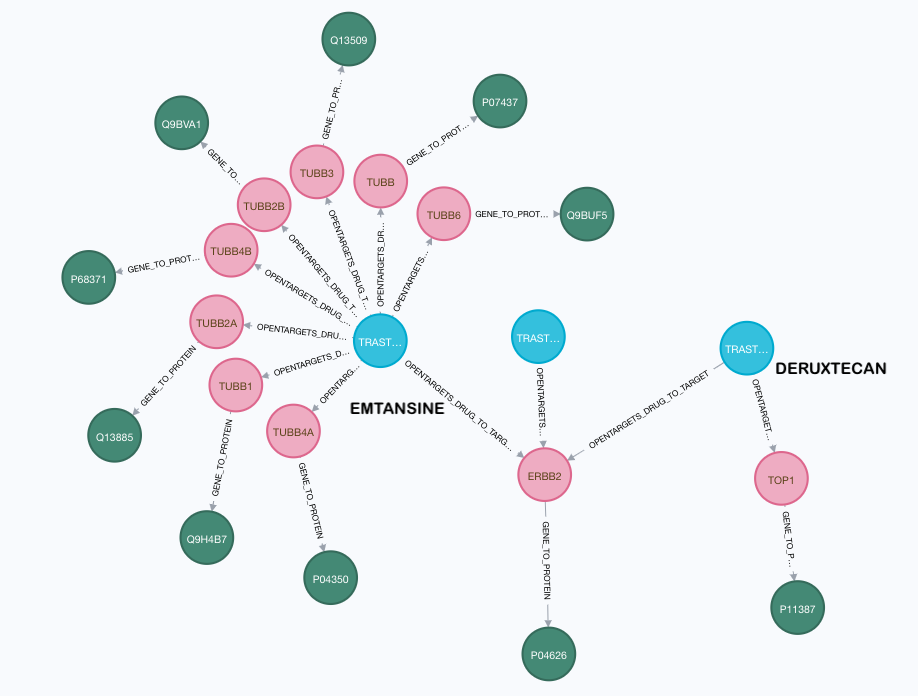

In [7]:
from IPython.display import Image
Image(filename = "herceptin_genes.png", width = 800)

In [8]:
# drug to gene (lit term) to other lit term; drug to disease 

query="""
match (drug:Drug)-[r1:OPENTARGETS_DRUG_TO_TARGET]->(gene:Gene)<-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt:LiteratureTriple)-[]-(l2:LiteratureTerm)
where toLower(drug.label) contains "trastuzumab"
match (drug)-[r4]->(disease:Disease)
set disease.name = disease.label
return drug.label, gene.name, disease.name, 
        l1.name as term1, lt.predicate as pred1, l2.name as term2 
"""
df_complex= query_to_df(query)
df_complex


match (drug:Drug)-[r1:OPENTARGETS_DRUG_TO_TARGET]->(gene:Gene)<-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt:LiteratureTriple)-[]-(l2:LiteratureTerm)
where toLower(drug.label) contains "trastuzumab"
match (drug)-[r4]->(disease:Disease)
set disease.name = disease.label
return drug.label, gene.name, disease.name, 
        l1.name as term1, lt.predicate as pred1, l2.name as term2 



,drug.label,gene.name,disease.name,term1,pred1,term2
0,TRASTUZUMAB EMTANSINE,ERBB2,neoplasm (disease),ERBB2,INTERACTS_WITH,BRAF
1,TRASTUZUMAB EMTANSINE,ERBB2,breast carcinoma,ERBB2,INTERACTS_WITH,BRAF
2,TRASTUZUMAB EMTANSINE,ERBB2,enterobiasis,ERBB2,INTERACTS_WITH,BRAF
3,TRASTUZUMAB EMTANSINE,ERBB2,neoplasm (disease),ERBB2,INTERACTS_WITH,BRAF gene
4,TRASTUZUMAB EMTANSINE,ERBB2,breast carcinoma,ERBB2,INTERACTS_WITH,BRAF gene
...,...,...,...,...,...,...
33158,TRASTUZUMAB,ERBB2,breast carcinoma,ERBB2,INTERACTS_WITH,AKT1
33159,TRASTUZUMAB,ERBB2,breast carcinoma,ERBB2,INTERACTS_WITH,Proto-Oncogene Proteins c-akt
33160,TRASTUZUMAB,ERBB2,breast carcinoma,ERBB2,INTERACTS_WITH,"Antibodies, Bispecific"
33161,TRASTUZUMAB,ERBB2,breast carcinoma,ERBB2,INTERACTS_WITH,Agent


In [9]:
# need to explore the table above!

In [ ]:
# get lit triples for herceptin target genes

# WHY no results?

gene_target = list(set(df['GeneTarget']))
query="""
match (gene:Gene)-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt:LiteratureTriple)-[]-(l2:LiteratureTerm)
where gene in {}
return gene.name, 
        l1.name as term1, lt.predicate as pred1, l2.name as term2 
""".format(gene_target)
df_easy= query_to_df(query)
df_easy

## Basic test2: drugs to disease

In [41]:
query="""
match (drug:Drug)
where toLower(drug.label) contains "tamoxifen"
return drug.label, drug.id
"""
df= query_to_df(query)
df


match (drug:Drug)
where toLower(drug.label) contains "tamoxifen"
return drug.label, drug.id



,drug.label,drug.id
0,TAMOXIFEN,http://identifiers.org/chembl.compound/CHEMBL83


In [42]:
# drugs to disease
query="""
match (drug:Drug)-[:OPENTARGETS_DRUG_TO_DISEASE]->(disease:Disease)
where drug.id =  'http://identifiers.org/chembl.compound/CHEMBL83'
return drug.label, drug.id, disease.label
"""
df= query_to_df(query)
df


match (drug:Drug)-[:OPENTARGETS_DRUG_TO_DISEASE]->(disease:Disease)
where drug.id =  'http://identifiers.org/chembl.compound/CHEMBL83'
return drug.label, drug.id, disease.label



,drug.label,drug.id,disease.label
0,TAMOXIFEN,http://identifiers.org/chembl.compound/CHEMBL83,enterobiasis


In [15]:
# drug to gene to protein to pathway
query="""
match (drug:Drug)-[:OPENTARGETS_DRUG_TO_TARGET]->(gene:Gene)-[]->(p:Protein)-[]->(path:Pathway)
where drug.id =  'http://identifiers.org/chembl.compound/CHEMBL83'
return drug.label,  gene.name as GeneTarget, 
        collect(distinct p.name) as proteinProducts, collect(path.name) as pathways
order by drug.label
"""
df= query_to_df(query)
df


match (drug:Drug)-[:OPENTARGETS_DRUG_TO_TARGET]->(gene:Gene)-[]->(p:Protein)-[]->(path:Pathway)
where drug.id =  'http://identifiers.org/chembl.compound/CHEMBL83'
return drug.label,  gene.name as GeneTarget, 
        collect(distinct p.name) as proteinProducts, collect(path.name) as pathways
order by drug.label



,drug.label,GeneTarget,proteinProducts,pathways
0,TAMOXIFEN,ESR1,[P03372],"[Estrogen-dependent gene expression, Extra-nuc..."


## Exploration of enterobiasis

In [43]:
# find all drugs for enterobiasis and their gene targets
query="""
match (g:Gene)-[]-(drug:Drug)-[]-(d:Disease)
where d.label = 'enterobiasis'
return drug.label, d.label, g.name
"""
df= query_to_df(query)
df


match (g:Gene)-[]-(drug:Drug)-[]-(d:Disease)
where d.label = 'enterobiasis'
return drug.label, d.label, g.name



,drug.label,d.label,g.name
0,CAPIVASERTIB,enterobiasis,AKT2
1,CAPIVASERTIB,enterobiasis,AKT3
2,CAPIVASERTIB,enterobiasis,AKT1
3,ENTINOSTAT,enterobiasis,HDAC1
4,ENTINOSTAT,enterobiasis,HDAC9
...,...,...,...
285,ACOLBIFENE,enterobiasis,ESR1
286,CAL,enterobiasis,PTHLH
287,MARGETUXIMAB,enterobiasis,ERBB2
288,HEMAY-022,enterobiasis,ERBB2


In [18]:
drugs_list = list(set(df['drug.label']))
drugs_list

['PF-04691502',
 'INDIBULIN',
 'MARIMASTAT',
 'MCS-110',
 'RG-7666',
 'TAMOXIFEN',
 'PICTILISIB',
 'ACOLBIFENE',
 'T-DM1',
 'VINORELBINE',
 'CAPIVASERTIB',
 'DACTOLISIB',
 'EFAPROXIRAL',
 'GLEMBATUMUMAB',
 'BGT-226',
 'ENMD-981693',
 'DOCETAXEL',
 'TASELISIB',
 'ERIBULIN',
 'SAPITINIB',
 'ENTINOSTAT',
 'PACLITAXEL',
 'FORETINIB',
 'AMG-888',
 'SAMOTOLISIB',
 'VANTICTUMAB',
 'APRICOXIB',
 'SAR-566658',
 'APITOLISIB',
 'LONAPRISAN',
 'LABETUZUMAB',
 'TRASTUZUMAB EMTANSINE',
 'IROSUSTAT',
 'BRE-3 90Y',
 'ICRUCUMAB',
 'BMS-754807',
 'PYROTINIB',
 'SAGOPILONE',
 'ETIRINOTECAN PEGOL',
 'BMS-690514',
 'IMETELSTAT SODIUM',
 'SR16234',
 'HEMAY-022',
 'BUPARLISIB',
 'GEDATOLISIB',
 'DUSIGITUMAB',
 'SERIBANTUMAB',
 'ABEMACICLIB',
 'RALIMETINIB',
 'ESTROGENS, ESTERIFIED',
 'MARGETUXIMAB',
 'LUCITANIB',
 'GLEMBATUMUMAB VEDOTIN',
 'TRASTUZUMAB DERUXTECAN',
 'KW-2450',
 'FLUOXYMESTERONE',
 'BRILANESTRANT',
 'ERTUMAXOMAB',
 'CUDC-101',
 'LUMRETUZUMAB',
 'CAL',
 'POZIOTINIB',
 'VELIPARIB',
 'ENMD-2076'

In [50]:
query="""
match(drug:Drug)-[]-(d:Disease)
where drug.label in {}
with drug, d
order by d.label desc
return drug.label, collect (d.label) as diseases
""".format(drugs_list)

df= query_to_df(query)
data=session.run(query).data()
print(json.dumps(data, indent=2))

[
  {
    "drug.label": "POZIOTINIB",
    "diseases": [
      "upper aerodigestive tract neoplasm",
      "non-small cell lung carcinoma (disease)",
      "lung adenocarcinoma",
      "enterobiasis"
    ]
  },
  {
    "drug.label": "DACTOLISIB",
    "diseases": [
      "transitional cell carcinoma",
      "neoplasm (disease)",
      "enterobiasis"
    ]
  },
  {
    "drug.label": "DOCETAXEL",
    "diseases": [
      "squamous cell carcinoma",
      "non-small cell lung carcinoma (disease)",
      "enterobiasis",
      "drug-induced liver injury"
    ]
  },
  {
    "drug.label": "ENMD-2076",
    "diseases": [
      "soft tissue sarcoma",
      "fibrosarcoma (disease)",
      "enterobiasis",
      "clear cell adenocarcinoma"
    ]
  },
  {
    "drug.label": "SAGOPILONE",
    "diseases": [
      "small cell lung carcinoma",
      "enterobiasis",
      "central nervous system neoplasm"
    ]
  },
  {
    "drug.label": "APITOLISIB",
    "diseases": [
      "renal cell carcinoma (disease)",


In [35]:
df.to_csv("query_results/enterobiasis_drugs.tsv", sep="\t", index=False)

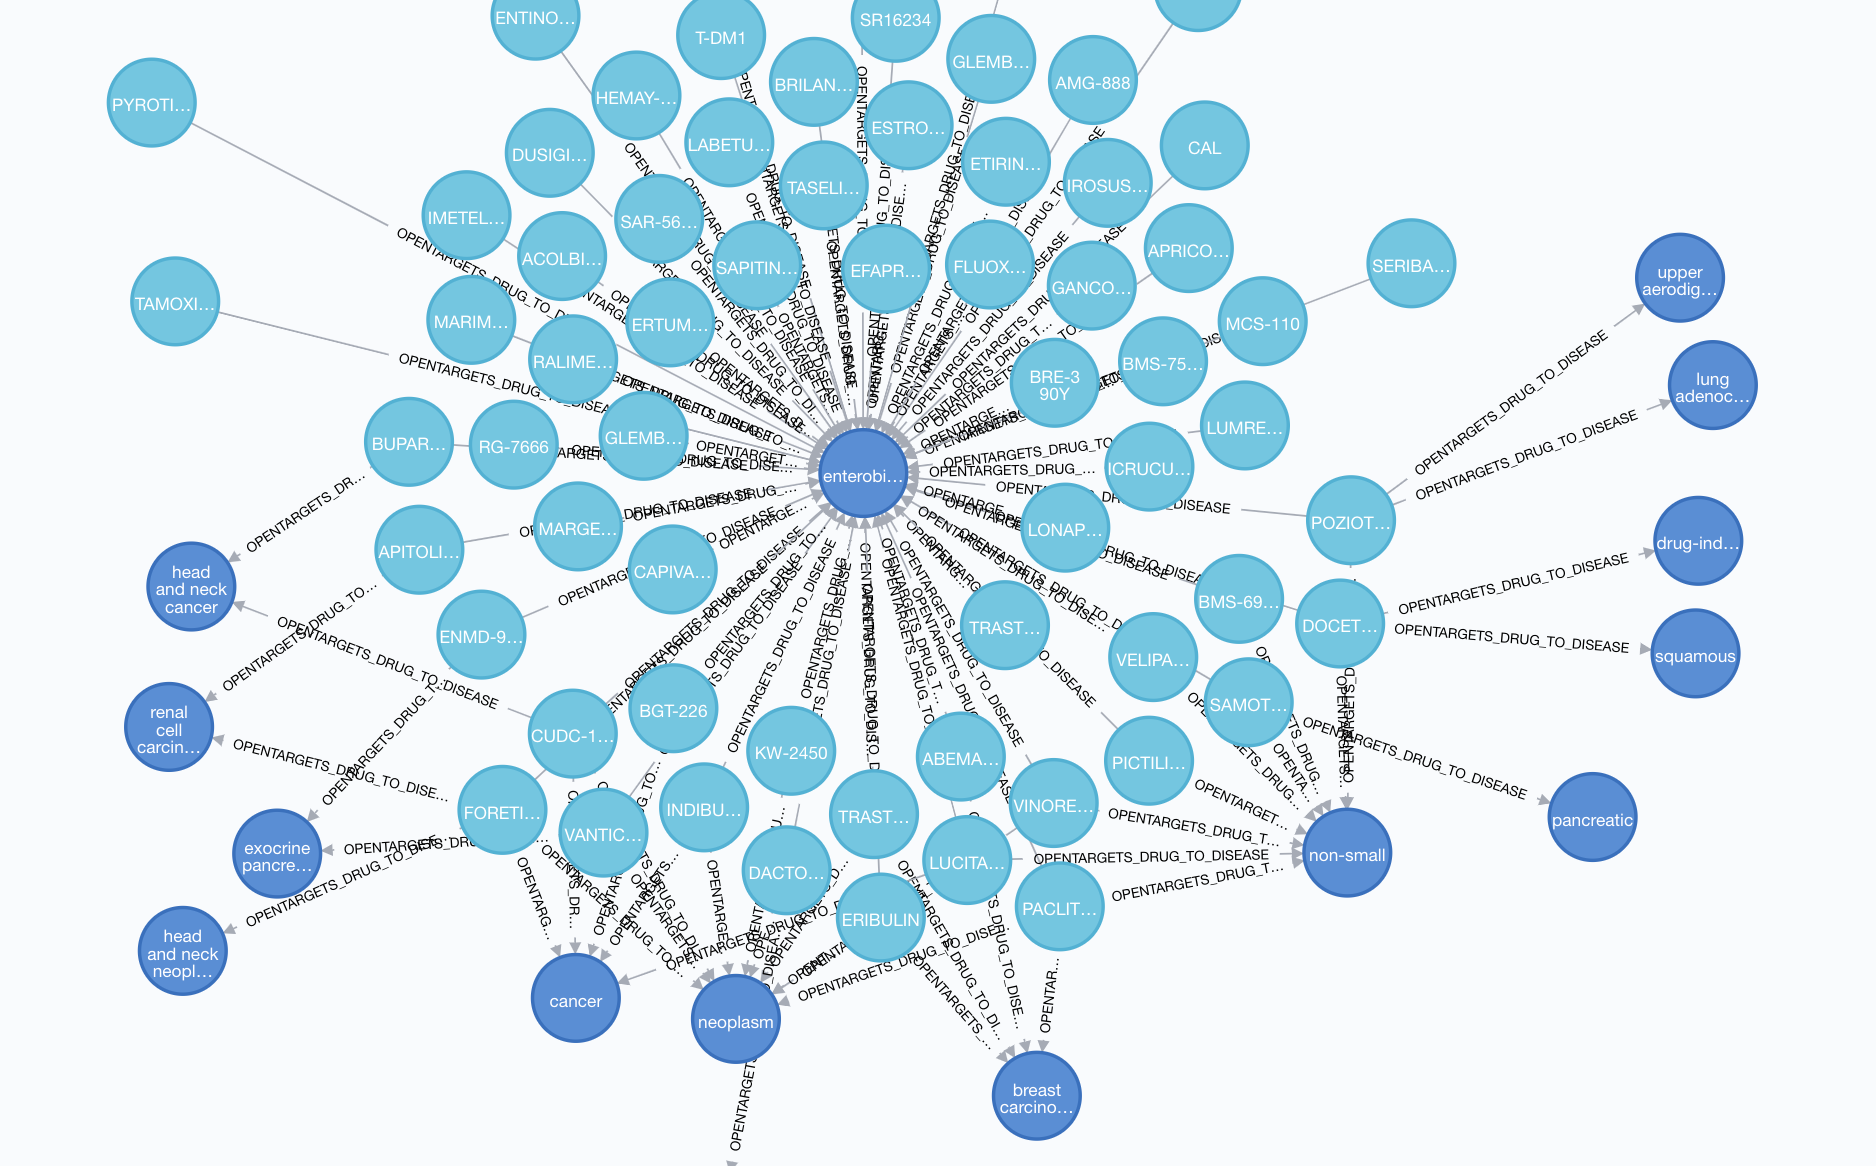

In [51]:
from IPython.display import Image
Image(filename = "figures/enterobiasis.png", width = 800)
